# Master Thesis in Economics
University of Copenhagen summer 2024

Authors: Cecilie Brøchner & Emma Vorregaard (code by Emma Vorregaard)

Supervisor:  Heino Bohn Nielsen

#### Research question

Does the combination of non-linear econometric models and machine learning techniques improve the predictability of economic or financial downturns compared to more traditional econometric models?

#### Description

The purpose of our master thesis is to develop a model that combines non-linear models (such as probit, logit or Markov-switching regression models) with machine learning (possibly deep neural networks) in order to predict economic or financial downturns. Traditional econometric models often face limitations with complex and large datasets where machine learning, however, is highly effective in handling big data and predict the outcomes hereof. We seek to improve the ability to anticipate and prepare for economic downturns utilizing the accuracy, reliability, and early warning capabilities of machine learning using economic and financial theory to select and gather time series data on economic indicators thereof. 

Throughout our research and paper, we draw inspiration from the following papers “Hidden Markov models as recurrent neural networks: an application to Alzheimer's disease” by Matt Baucum, Anahita Khojandi, Theodore Papamarkou, “China's GDP forecasting using Long Short Term Memory Recurrent Network and Hidden Markov Model” by Hunhuan Zhang, Jiaqi Wen, Zhen Yang and “Predicting US recessions with leading indicators via neural network models” by Min Qi with more to come.

Relevance: Forecasting future Time Series values is a quite common problem in practice. Time Series data introduces a “hard dependency” on previous time steps, so the assumption that independence of observations doesn’t hold.

### Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import tensorflow as tf
from tensorflow import keras
import warnings
import sys

# import our own functions
sys.path.append("/Users/emmavorregaard/Desktop/Speciale")
import myfunctions as func

# plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 8, 5

# set seed
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# other
warnings.filterwarnings('ignore')
#tf.config.set_visible_devices([], 'GPU')  # This forces TensorFlow to use CPU only

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-05-02 14:45:42.602108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data
Data is from Federal Reserve Economic Data (FRED). It is the quarterly database for macroeconomic research (FRED-QD). The database is updated in real time using the FRED database. A full description of data can be found here:

https://s3.amazonaws.com/real.stlouisfed.org/wp/2020/2020-005.pdf

https://files.stlouisfed.org/files/htdocs/publications/review/2021/01/14/fred-qd-a-quarterly-database-for-macroeconomic-research.pdf

The database covers the period of 1959-Q1 to 2023-Q4.

In [2]:
# Import data (.csv file) as a pandas dataframe
macro_data = pd.read_csv("macro_data.csv")
macro_data = macro_data.iloc[2:].reset_index(drop=True) # removes irrelevant lines
macro_data.head()

,sasdate,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
0,3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,...,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,59.1400,3.1765,18.6211
1,6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,...,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,61.5867,3.1012,19.2899
2,9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,...,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,63.0600,3.0720,18.9544
3,12/1/1959,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,...,349400.81,254967.79,2429055.21,2079.05,1517.14,137.0372,57.7633,62.0200,3.1572,17.8221
4,3/1/1960,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,...,362821.95,278692.55,2451394.44,2087.97,1603.82,130.1872,56.2767,60.1933,3.3850,16.8284


#### Data Preprocessing

Before using the data we need to 
- drop irrelevant columns
- handle missing values
- transform series so that they are stationary i.e. mean zero and variance one
- normalize/standardize data i.e. series need to be on the same scale

##### Drop columns
The industrial production index (IPI) (ID # 23-34 and 194-196)
- Comment: Monthly economic indicator measuring real output in the manufacturing, mining, electric, and gas industries, relative to a base year

Employment and Unemployment (ID # 35-56, 60-80, 197, 198, 220, 221)

Housing (ID # 84-87, 227-230)

Prices (ID # 104-119, 207-215, 233)

Earning and Productivity (ID # 131-139, 216)

Question for supervisor: Is unit labour cost a measure for productivity?

In [3]:
# import appendix that contains IDs
appendix_data = pd.read_csv("FRED-QD_updated_appendix.csv", sep=";", encoding='unicode_escape')
appendix_data.head()

,ID,SW ID,TCODE,SW Factors,FRED MNEMONIC,SW MNEMONIC,DESCRIPTION,Group
0,1,1,5,0,GDPC1,GDP,"Real Gross Domestic Product, 3 Decimal (Billio...",1
1,2,2,5,0,PCECC96,Consumption,Real Personal Consumption Expenditures (Billio...,1
2,3,3,5,1,PCDGx,Cons:Dur,Real personal consumption expenditures: Durabl...,1
3,4,4,5,1,PCESVx,Cons:Svc,Real Personal Consumption Expenditures: Servic...,1
4,5,5,5,1,PCNDx,Cons:NonDur,Real Personal Consumption Expenditures: Nondur...,1


In [11]:
# define the ranges of IDs to drop (inclusive)
id_ranges_to_drop = [
    range(23, 57),  # 23-36
    range(60, 81),  # 60-80
    range(84, 88),  # 84-87
    range(104, 120),  # 104-119
    range(131, 140),  # 131-139
    range(194, 199),  # 194-198
    range(207, 217),  # 207-216
    range(227, 231),  # 227-230
    [220, 221, 233]  # single IDs
]

# create list
ids_to_drop = [id for subrange in id_ranges_to_drop for id in subrange]

# drop
appendix_data_cleaned = appendix_data[~appendix_data['ID'].isin(ids_to_drop)]

# use the cleaned appendix to filter on macro_data
variables_to_keep = list(appendix_data_cleaned['FRED MNEMONIC'].dropna().unique())
variables_to_keep.insert(0, 'sasdate')

# filter on macro_data
macro_data_filtered = macro_data[variables_to_keep]

macro_data_filtered

,sasdate,GDPC1,PCECC96,PCDGx,PCESVx,PCNDx,GPDIC1,FPIx,Y033RC1Q027SBEAx,PNFIx,...,TLBSNNBx,TLBSNNBBDIx,TABSNNBx,TNWBSNNBx,TNWBSNNBBDIx,CNCFx,S&P 500,S&P: indust,S&P div yield,S&P PE ratio
0,3/1/1959,3352.129,2039.017,68.6651,1374.1739,689.1172,354.894,357.0174,47.8021,171.0783,...,333245.24,266668.11,2426352.41,2092.54,1674.48,124.9663,55.5167,59.1400,3.1765,18.6211
1,6/1/1959,3427.667,2070.508,71.2495,1394.7096,694.8197,382.500,368.0640,49.2332,176.0004,...,345845.01,273329.36,2434975.21,2088.55,1650.63,126.5305,57.5067,61.5867,3.1012,19.2899
2,9/1/1959,3430.057,2092.138,72.6270,1413.6627,697.4699,357.798,371.9585,50.8372,180.7406,...,354808.05,275139.48,2434604.03,2079.21,1612.34,128.9557,58.7300,63.0600,3.0720,18.9544
3,12/1/1959,3439.832,2094.495,69.1573,1430.8157,701.7617,369.442,367.6452,50.7342,180.2333,...,349400.81,254967.79,2429055.21,2079.05,1517.14,137.0372,57.7633,62.0200,3.1572,17.8221
4,3/1/1960,3517.181,2114.532,71.3815,1443.7405,703.5338,406.581,379.9162,52.4985,186.4967,...,362821.95,278692.55,2451394.44,2087.97,1603.82,130.1872,56.2767,60.1933,3.3850,16.8284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,12/1/2022,21989.981,15171.391,1957.2442,9921.6708,3324.0595,4058.491,3877.3100,1249.3026,3169.9843,...,9276520.51,424693.87,22909454.28,13538.31,619.81,2184.2841,3851.9733,5354.0300,1.7241,19.4586
256,3/1/2023,22112.329,15312.850,2022.2964,9998.3770,3328.1624,3963.689,3906.7881,1236.2218,3214.5024,...,9281080.61,431633.01,22529466.16,13149.36,611.53,2150.2250,4002.9667,5575.1967,1.6935,20.8628
257,6/1/2023,22225.350,15343.553,2020.6395,10022.4957,3335.8135,4014.121,3956.7681,1259.4442,3272.7346,...,9310397.75,427765.74,22730132.97,13313.58,611.69,2176.5179,4204.3367,5985.9900,1.6311,22.5813
258,9/1/2023,22490.692,15461.382,2053.6639,10078.0744,3367.6562,4111.053,3982.1618,1245.3474,3284.5326,...,9282329.82,409326.00,22640205.16,13252.67,584.41,2267.7108,4458.1800,6384.7233,NaN,24.5452


##### Missing Values
Continuity in data is important for our models.

We notice that multiple variables are missing an observation for the last period (2023-Q4) so we drop that row before handling the rest of the missing values.

In [14]:
# remove last observation
macro_data_filtered = macro_data_filtered[:-1]

# calculate missing values for each column
total_missing = macro_data_filtered.isnull().sum()

# initialize DataFrame to store results
missing_details = pd.DataFrame(total_missing, columns=['Total_Missing'])

# determine where missing values occur
missing_details['Beginning'] = macro_data_filtered.iloc[:1].isnull().any()
missing_details['End'] = macro_data_filtered.iloc[-1:].isnull().any()

# create a function to classify the location of missing values
def classify_missing(beginning, end):
    if beginning and end:
        return 'Both'
    elif beginning:
        return 'Beginning'
    elif end:
        return 'End'
    else:
        return 'None'

# apply the classification function
missing_details['Missing_Location'] = missing_details.apply(
    lambda row: classify_missing(row['Beginning'], row['End']), axis=1)

# drop
missing_details.drop(['Beginning', 'End'], axis=1, inplace=True)

# display
missing_details = missing_details[missing_details['Missing_Location']!='None']

# split
missing_details_both = missing_details[missing_details['Missing_Location']=='Both'] # no variable has missing value in beginning and end
missing_details_end = missing_details[missing_details['Missing_Location']=='End'] # no variable has missing value in end
missing_details_beginning = missing_details[missing_details['Missing_Location']=='Beginning']

missing_details_beginning['Years'] = missing_details_beginning['Total_Missing']/4
missing_details_beginning

,Total_Missing,Missing_Location,Years
OUTMS,112,Beginning,28.00
PERMIT,4,Beginning,1.00
CMRMTSPLx,32,Beginning,8.00
RSAFSx,132,Beginning,33.00
ACOGNOx,132,Beginning,33.00
ANDENOx,36,Beginning,9.00
INVCQRMTSPL,32,Beginning,8.00
WPU0531,32,Beginning,8.00
OILPRICEx,108,Beginning,27.00
ULCMFG,112,Beginning,28.00


In [15]:
# for now we leave these variables out in order to obtain as many observations as possible.
# list of variables to drop
variables_to_drop = list(missing_details_beginning.index.values)

# Drop the columns from the DataFrame
macro_data_filtered.drop(columns=variables_to_drop, inplace=True, errors='ignore')

# check for missing values
print('Number of missing values is ' + str(macro_data_filtered.isnull().sum().sum()))

Number of missing values is 0


##### Transformations
A Times Series is said to be stationary when the mean and variance remain constant over time. A Time Series has a trend if the mean is varying over time. Often you can eliminate it and make the series stationary by applying log transformation(s).

In appendix to the database we find descriptions and data transformations for the series. The column "tcode" tells how to transform the series to that they are stationary. 

It consists of the following data transformations:

1. No transformation
2. $Δx_t$
3. $Δx_t-Δx_{t-1}$
4. $\log(x_t)$
5. $\Delta\log(x_t)$
6. $Δ\log(x_t)-Δ\log(x_{t-1})$
7. $\Delta(x_t/x_{t-1}-1)$

In [16]:
# reshape data into long format
macro_data_long = macro_data_filtered.melt(id_vars=['sasdate'])
macro_data_long['sasdate'] = pd.to_datetime(macro_data_long['sasdate'])

# make a new dataframe with variables and their transformation codes
appendix_data_sub = appendix_data[['FRED MNEMONIC','TCODE']]

# join TCODE onto data
macro_data_long = macro_data_long.merge(appendix_data_sub, left_on='variable', right_on='FRED MNEMONIC')

# adding a column with transformed values
macro_data_transformed = func.apply_transformations(macro_data_long)

In [17]:
# test that variables are indeed stationary
adf_tests = func.test_for_unit_roots_5pct(macro_data_transformed, 'variable', 'transformed_value')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [18]:
adf_tests_false = adf_tests[adf_tests['Reject Null Hypothesis at 5%'] == False]
adf_tests_false = adf_tests_false.merge(appendix_data, left_on='variable', right_on='FRED MNEMONIC')
adf_tests_false = adf_tests_false[['variable', 'ADF Statistic', 'p-value', 'DESCRIPTION',"TCODE"]]
adf_tests_false.head(20)

,variable,ADF Statistic,p-value,DESCRIPTION,TCODE
0,NWPIx,-0.202896,0.938176,Net Worth of Households and Nonprofit Organiza...,1
1,S&P div yield,-2.762343,0.063857,S&P's Composite Common Stock: Dividend Yield,2
2,TLBSHNOx,-2.418649,0.136542,Real Total Liabilities of Households and Nonpr...,5
3,TLBSNNBBDIx,-2.160265,0.220982,Nonfinancial Noncorporate Business Sector Liab...,1
4,TLBSNNCBBDIx,-2.844905,0.052140,Nonfinancial Corporate Business Sector Liabili...,1


##### Normalizing

## Investigating dpendent variable: Growth rate of GDP

In [19]:
gdp_df = transformed_df[transformed_df['variable'] == 'GDPC1']

gdp_df["output_growth_pct"] = np.log(gdp_df['value']).diff()*100
gdp_df["output_growth_pct_last_year"] = (np.log(gdp_df['value']) - np.log(gdp_df['value']).shift(4))*100

gdp_df.head()

/var/folders/48/2jtk_qg91r533f53jrxqk3940000gn/T/ipykernel_77319/4003767111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df["output_growth_pct"] = np.log(gdp_df['value']).diff()*100
/var/folders/48/2jtk_qg91r533f53jrxqk3940000gn/T/ipykernel_77319/4003767111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_df["output_growth_pct_last_year"] = (np.log(gdp_df['value']) - np.log(gdp_df['value']).shift(4))*100


,sasdate,variable,value,FRED MNEMONIC,TCODE,transformed_value,output_growth_pct,output_growth_pct_last_year
0,1960-03-01,GDPC1,3517.181,GDPC1,5,NaN,NaN,NaN
1,1960-06-01,GDPC1,3498.246,GDPC1,5,-0.005398,-0.539812,NaN
2,1960-09-01,GDPC1,3515.385,GDPC1,5,0.004887,0.488735,NaN
3,1960-12-01,GDPC1,3470.278,GDPC1,5,-0.012914,-1.291434,NaN
4,1961-03-01,GDPC1,3493.703,GDPC1,5,0.006727,0.672750,-0.669761


In [51]:
# import business cycle data (.csv file) as a pandas dataframe
business_cycles = pd.read_csv("business_cycles.csv", sep=";")
mapping = {
    'Q1': '-03-01',
    'Q2': '-06-01',
    'Q3': '-09-01',
    'Q4': '-12-01',
}
business_cycles["Start_date_dt"] = pd.to_datetime(business_cycles["Start_date"].replace(mapping, regex=True))
business_cycles["End_date_dt"] = pd.to_datetime(business_cycles["End_date"].replace(mapping, regex=True))
business_cycles = business_cycles[business_cycles['Start_year'] >= 1960]
business_cycles_dates = business_cycles[["Start_date_dt","End_date_dt"]]
business_cycles_dates.dtypes


Start_date_dt    datetime64[ns]
End_date_dt      datetime64[ns]
dtype: object

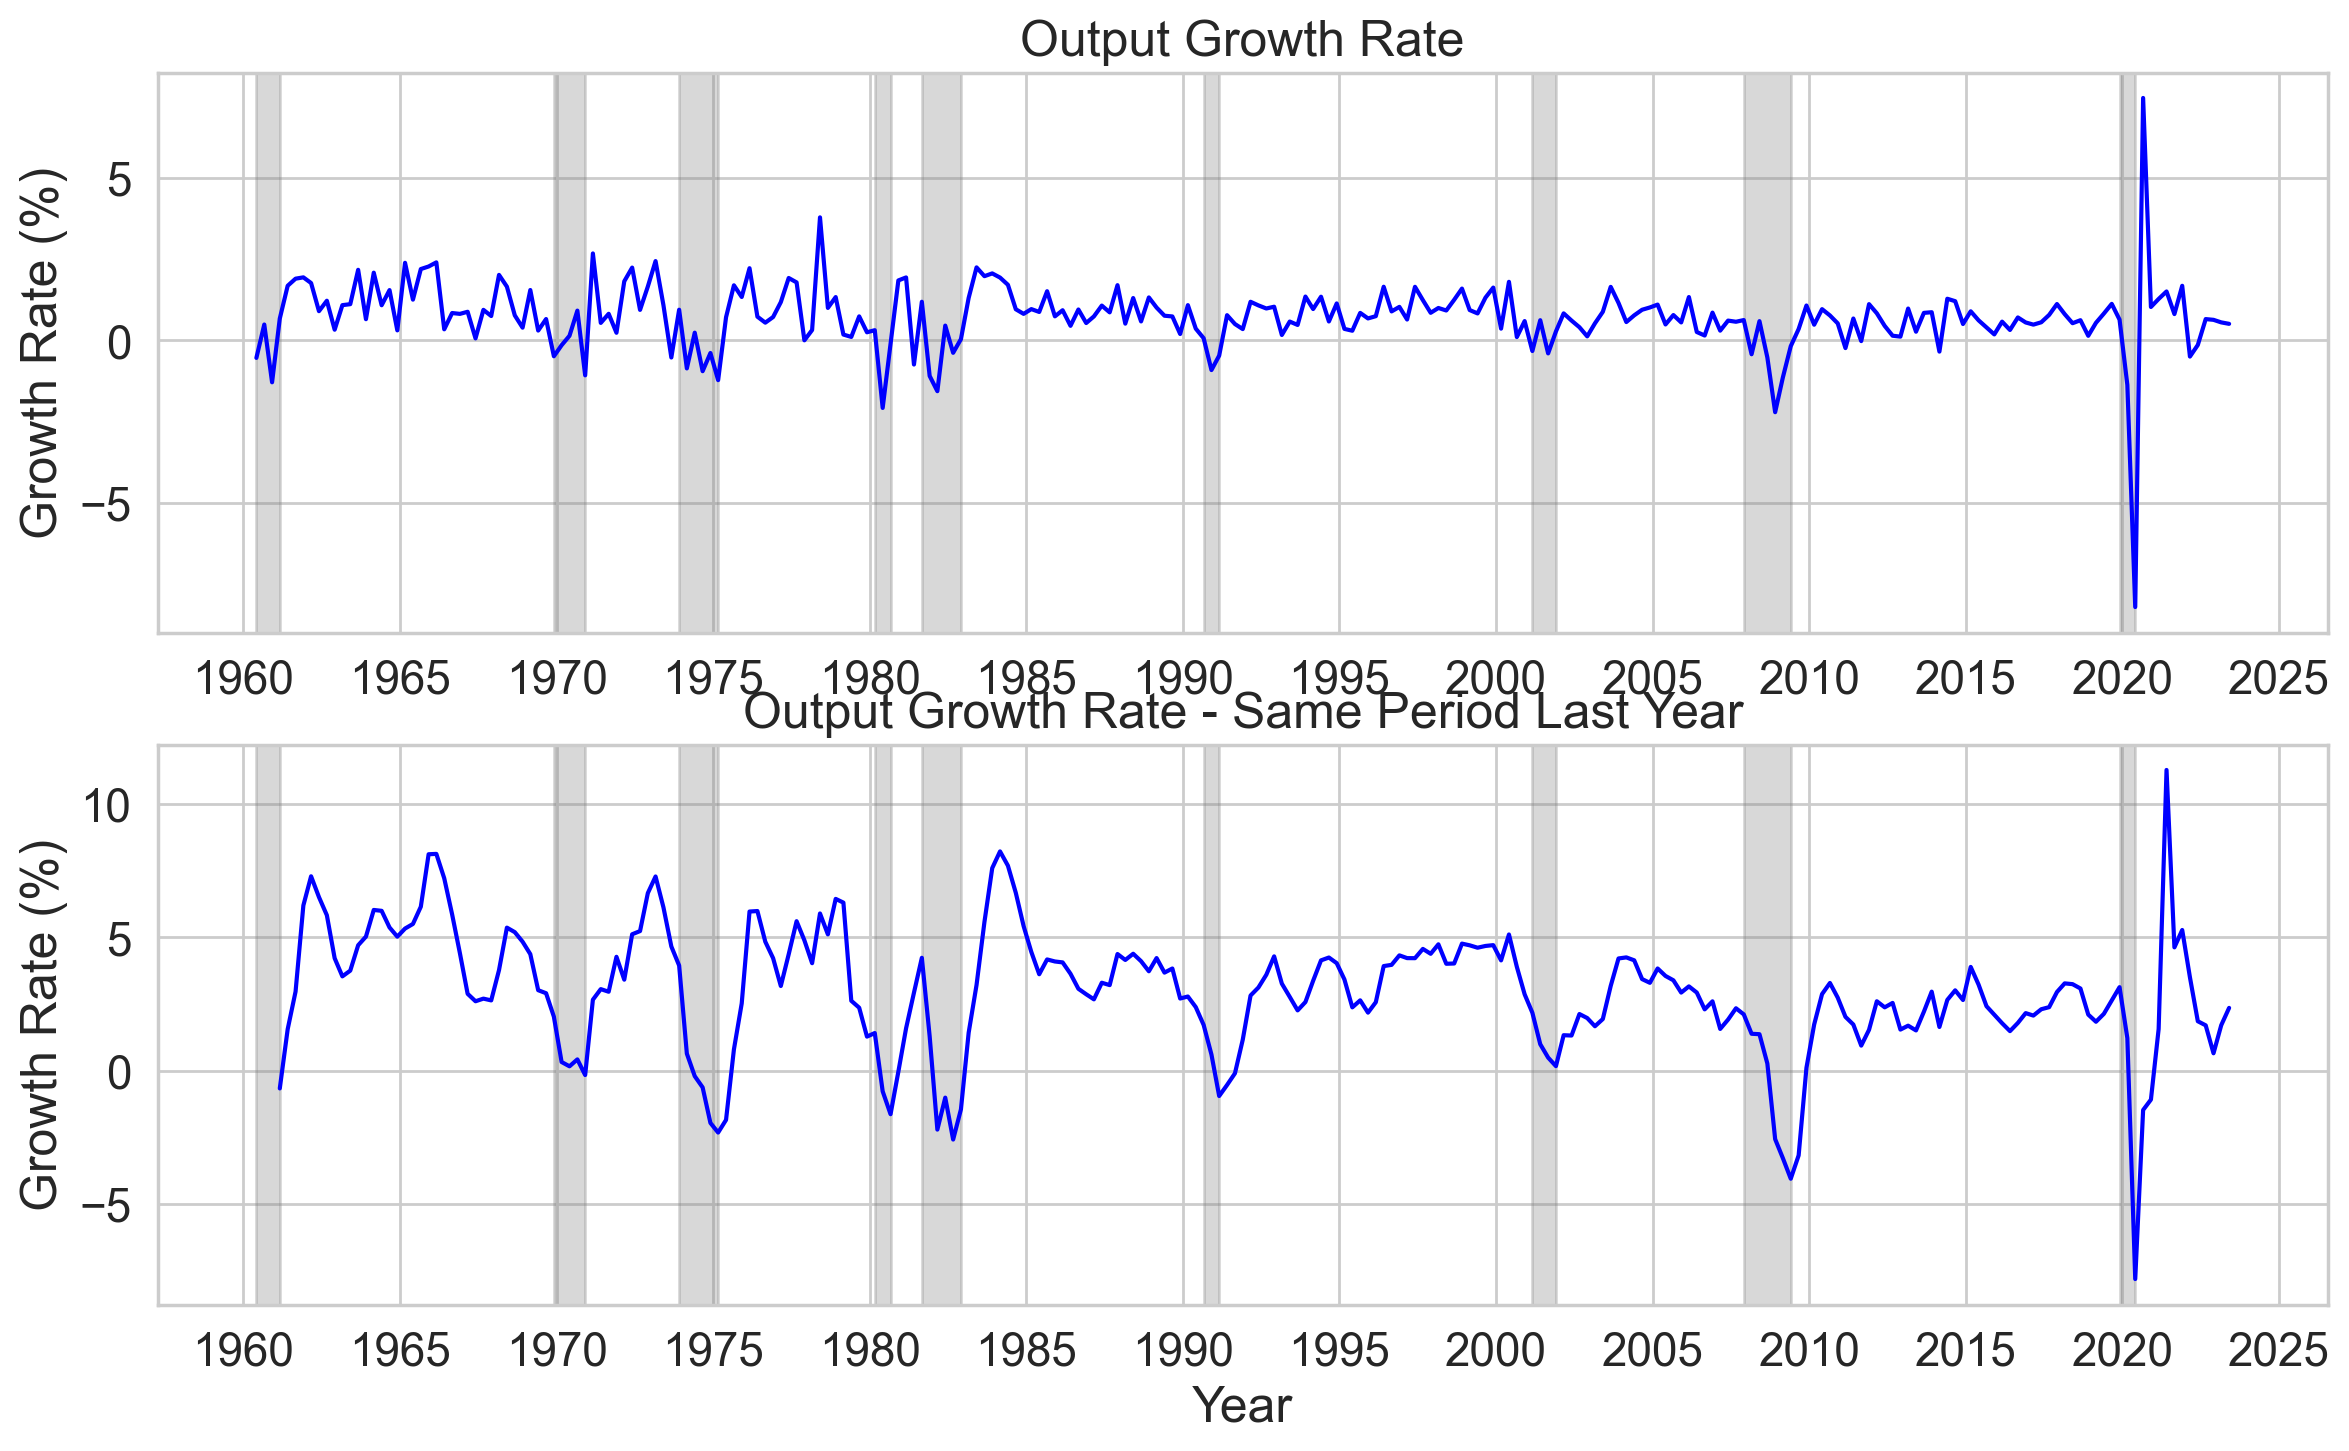

In [52]:
# Create the plot
fig, ax = plt.subplots(figsize=(14, 8), nrows=2, ncols=1)

# Plot the growth rate of output
ax[0].plot(gdp_df["sasdate"], gdp_df["output_growth_pct"], color='blue')
ax[1].plot(gdp_df["sasdate"], gdp_df["output_growth_pct_last_year"], color='blue')

# Add recession shading
for start, end in business_cycles_dates.itertuples(index=False):
    ax[0].axvspan(start, end, color='grey', alpha=0.3)
    ax[1].axvspan(start, end, color='grey', alpha=0.3)

# Set the title and labels
ax[0].set_title('Output Growth Rate')
ax[1].set_title('Output Growth Rate - Same Period Last Year')
ax[1].set_xlabel('Year')
ax[0].set_ylabel('Growth Rate (%)')
ax[1].set_ylabel('Growth Rate (%)')

# Format the x-axis to show the year
ax[0].xaxis.set_major_locator(mdates.YearLocator(5))  # Get a tick every 5 years
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick to show year only
ax[1].xaxis.set_major_locator(mdates.YearLocator(5))  # Get a tick every 5 years
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format tick to show year only

# Show the plot
plt.show()


In [50]:
# We need our variable to be stationary i.e. mean zero and variance one so we calculate:
print("The mean growth rate of output is " + str(round(gdp_df['output_growth_pct'].mean(), 4)))
print("The variance of the growth rate of output is " + str(round(gdp_df['output_growth_pct'].var(), 4)))
print("The mean growth rate of output from same period last year is " + str(round(gdp_df['output_growth_pct_last_year'].mean(), 4)))
print("The variance of growth rate of output from same period last year is " + str(round(gdp_df['output_growth_pct_last_year'].var(), 4)))

The mean growth rate of output is 0.7287
The variance of the growth rate of output is 1.1509
The mean growth rate of output from same period last year is 2.9444
The variance of growth rate of output from same period last year is 5.4394


We use output growth from the same period last year as the downturns in recessions are easier to identify. However mean and variance are not zero and one respectively.

## Deep learning (Recurrent Neural Networks)

Simple LSTM model

### Data Preprocessing

We’ll split it into training and test data:

In [ ]:
# simulated data to test code
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))
df_sim = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])

In [ ]:
# real data


In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [10]:
print(df)

          sine
0.0   0.248357
0.1   0.030701
0.2   0.522514
0.3   1.057035
0.4   0.272342
...        ...
99.5 -0.998345
99.6  0.096647
99.7 -0.418161
99.8 -0.953178
99.9 -0.303633

[1000 rows x 1 columns]


We need to predict the value at the current time step by using the history (n time steps from it). Here’s a generic function that does the job:

In [11]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
time_steps = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)
print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


We have our sequences in the shape (samples, time_steps, features).

### Modeling

The LSTM layer expects the number of time steps and the number of features to work properly. The rest of the model looks like a regular regression model. The most important thing to remember when training Time Series models is to not shuffle the data (the order of the data matters).

In [13]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2024-05-01 01:04:28.228417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 01:04:28.230118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 01:04:28.230814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/30


2024-05-01 01:05:49.127213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 01:05:49.128506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 01:05:49.129349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 2s 10ms/step - loss: 0.4309 - val_loss: 0.3779
Epoch 2/30
14/45 [========>.....................] - ETA: 0s - loss: 0.3310

2024-05-01 01:05:50.449779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 01:05:50.450763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 01:05:50.451430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/45 [==============================] - 0s 5ms/step - loss: 0.3333 - val_loss: 0.3317
Epoch 3/30
45/45 [==============================] - 0s 5ms/step - loss: 0.3213 - val_loss: 0.3238
Epoch 4/30
45/45 [==============================] - 0s 5ms/step - loss: 0.3192 - val_loss: 0.3208
Epoch 5/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3179 - val_loss: 0.3185
Epoch 6/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3169 - val_loss: 0.3166
Epoch 7/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3161 - val_loss: 0.3150
Epoch 8/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3153 - val_loss: 0.3136
Epoch 9/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3146 - val_loss: 0.3123
Epoch 10/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3139 - val_loss: 0.3110
Epoch 11/30
45/45 [==============================] - 0s 4ms/step - loss: 0.3132 - val_loss: 0.3098
Epoch 12/30
45/45 [==========

### Evaluation

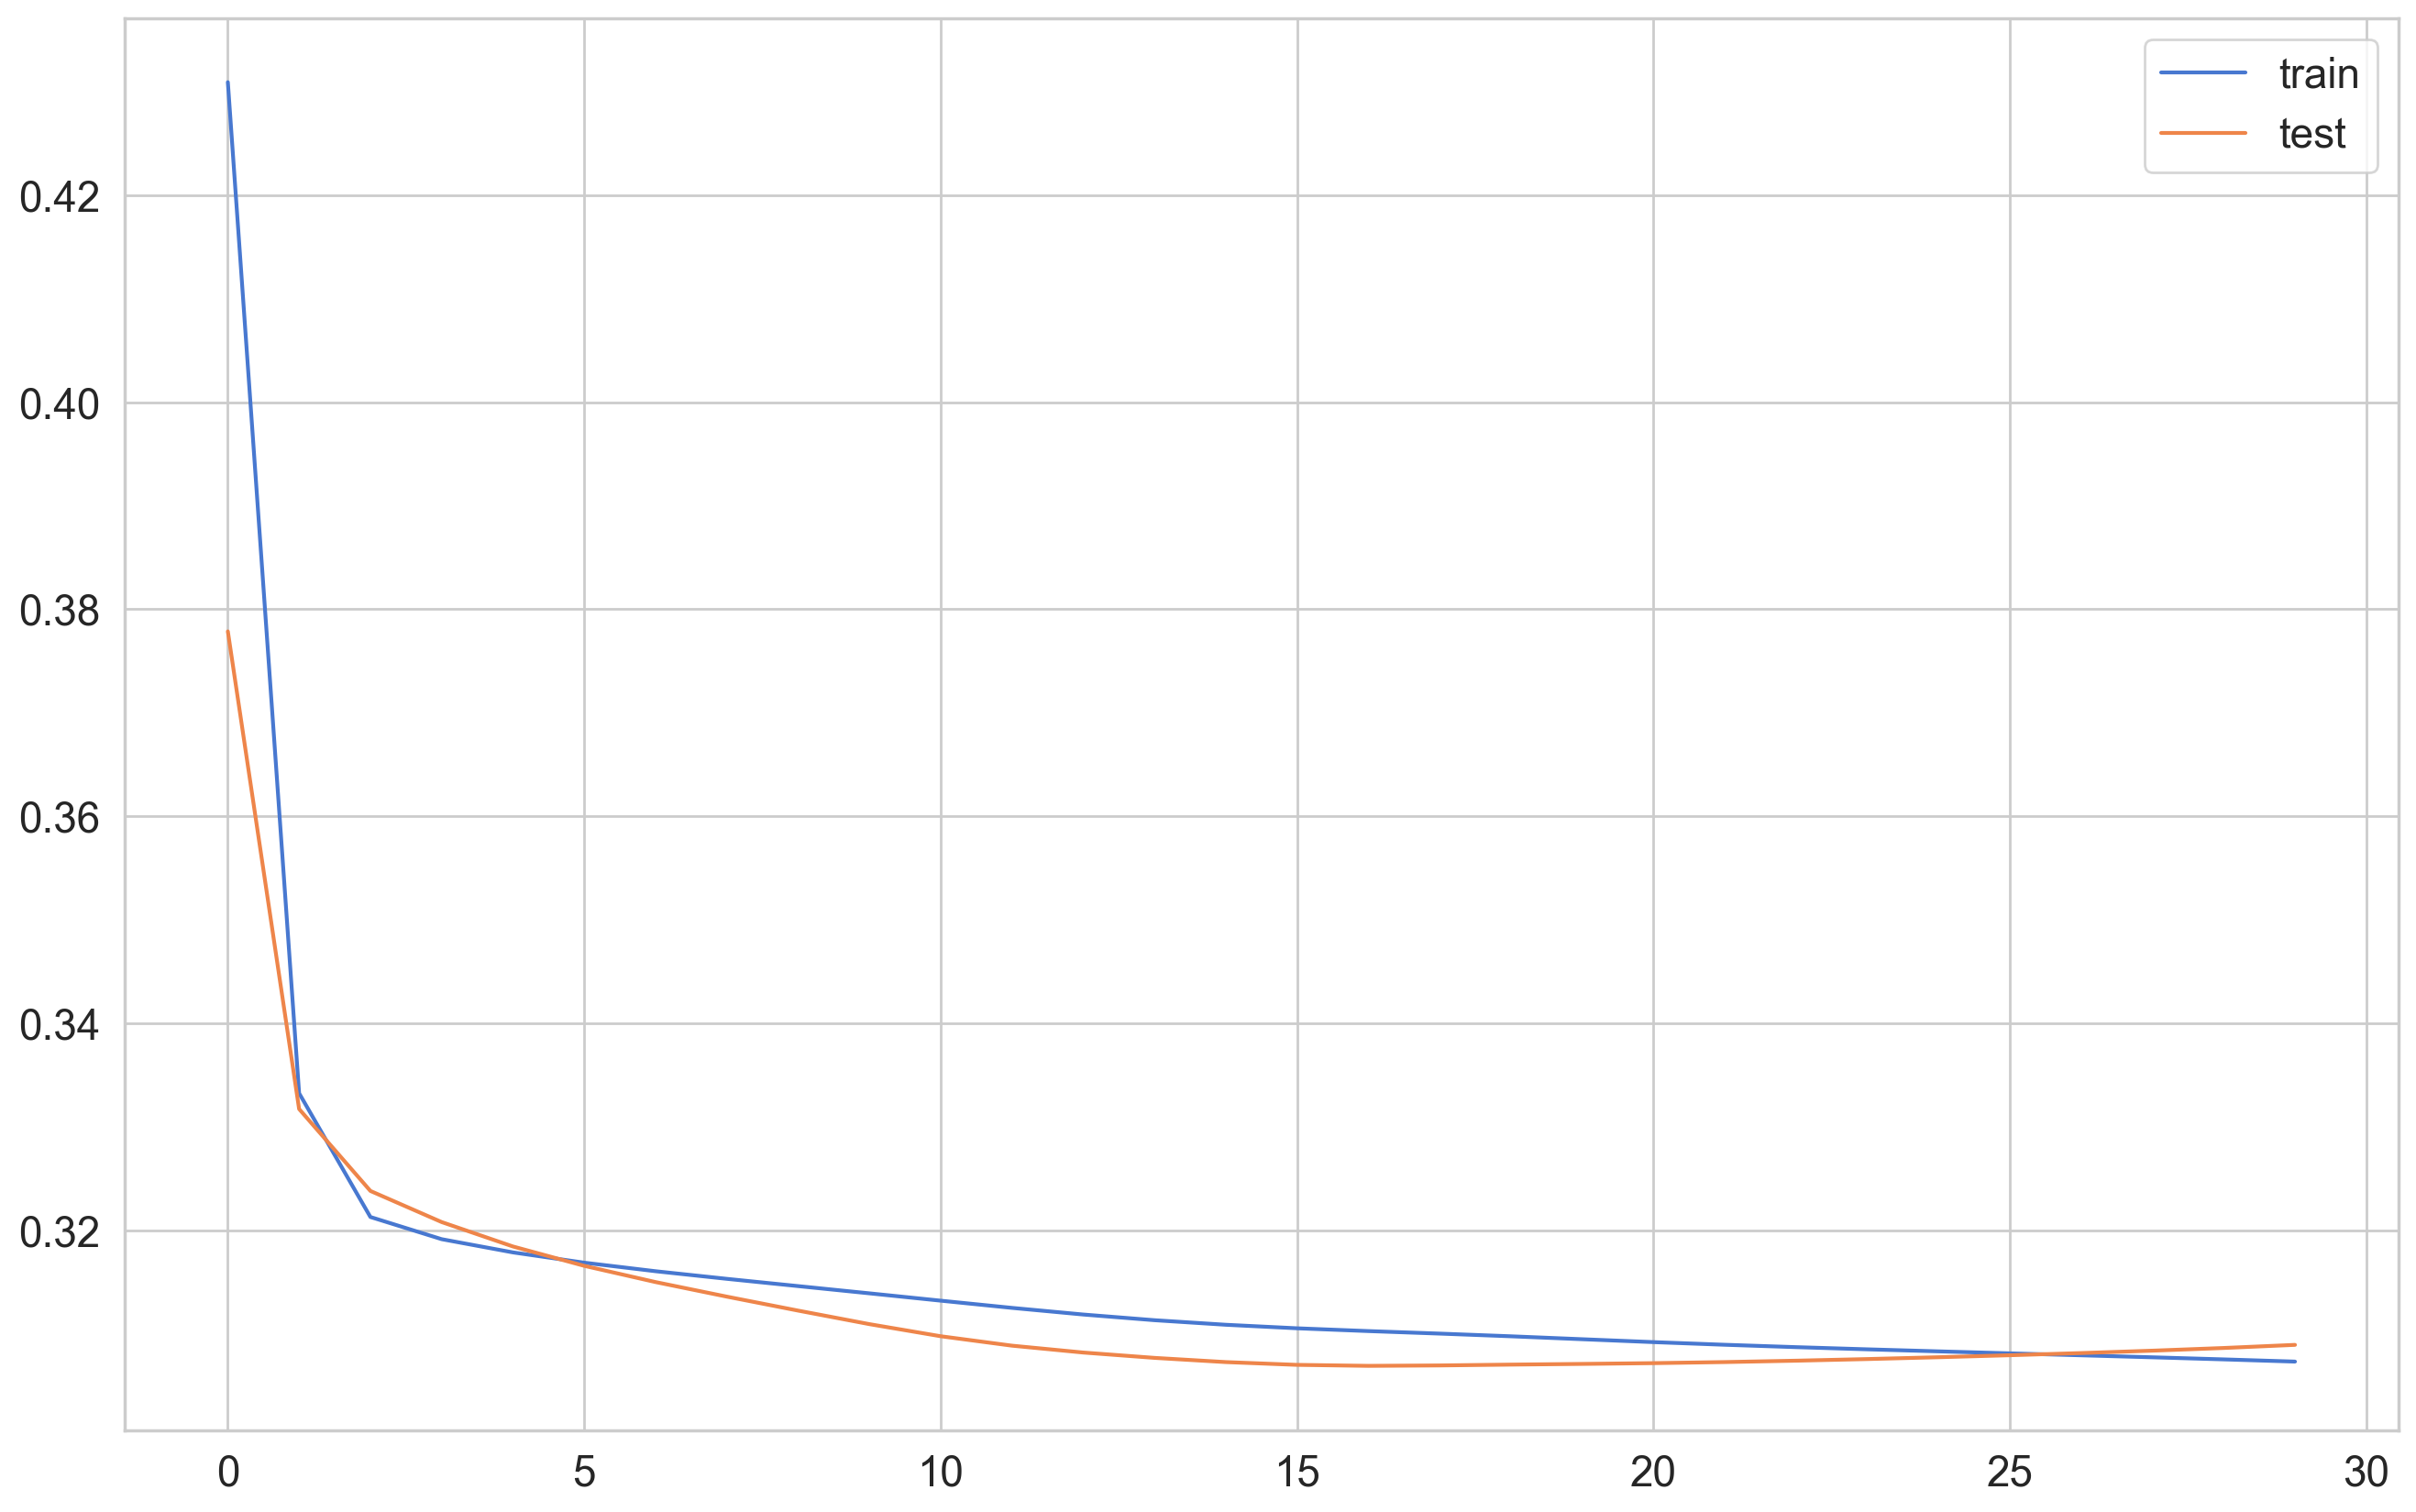

In [16]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [15]:
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


2024-05-01 01:06:53.922799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 01:06:53.923825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 01:06:53.924454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

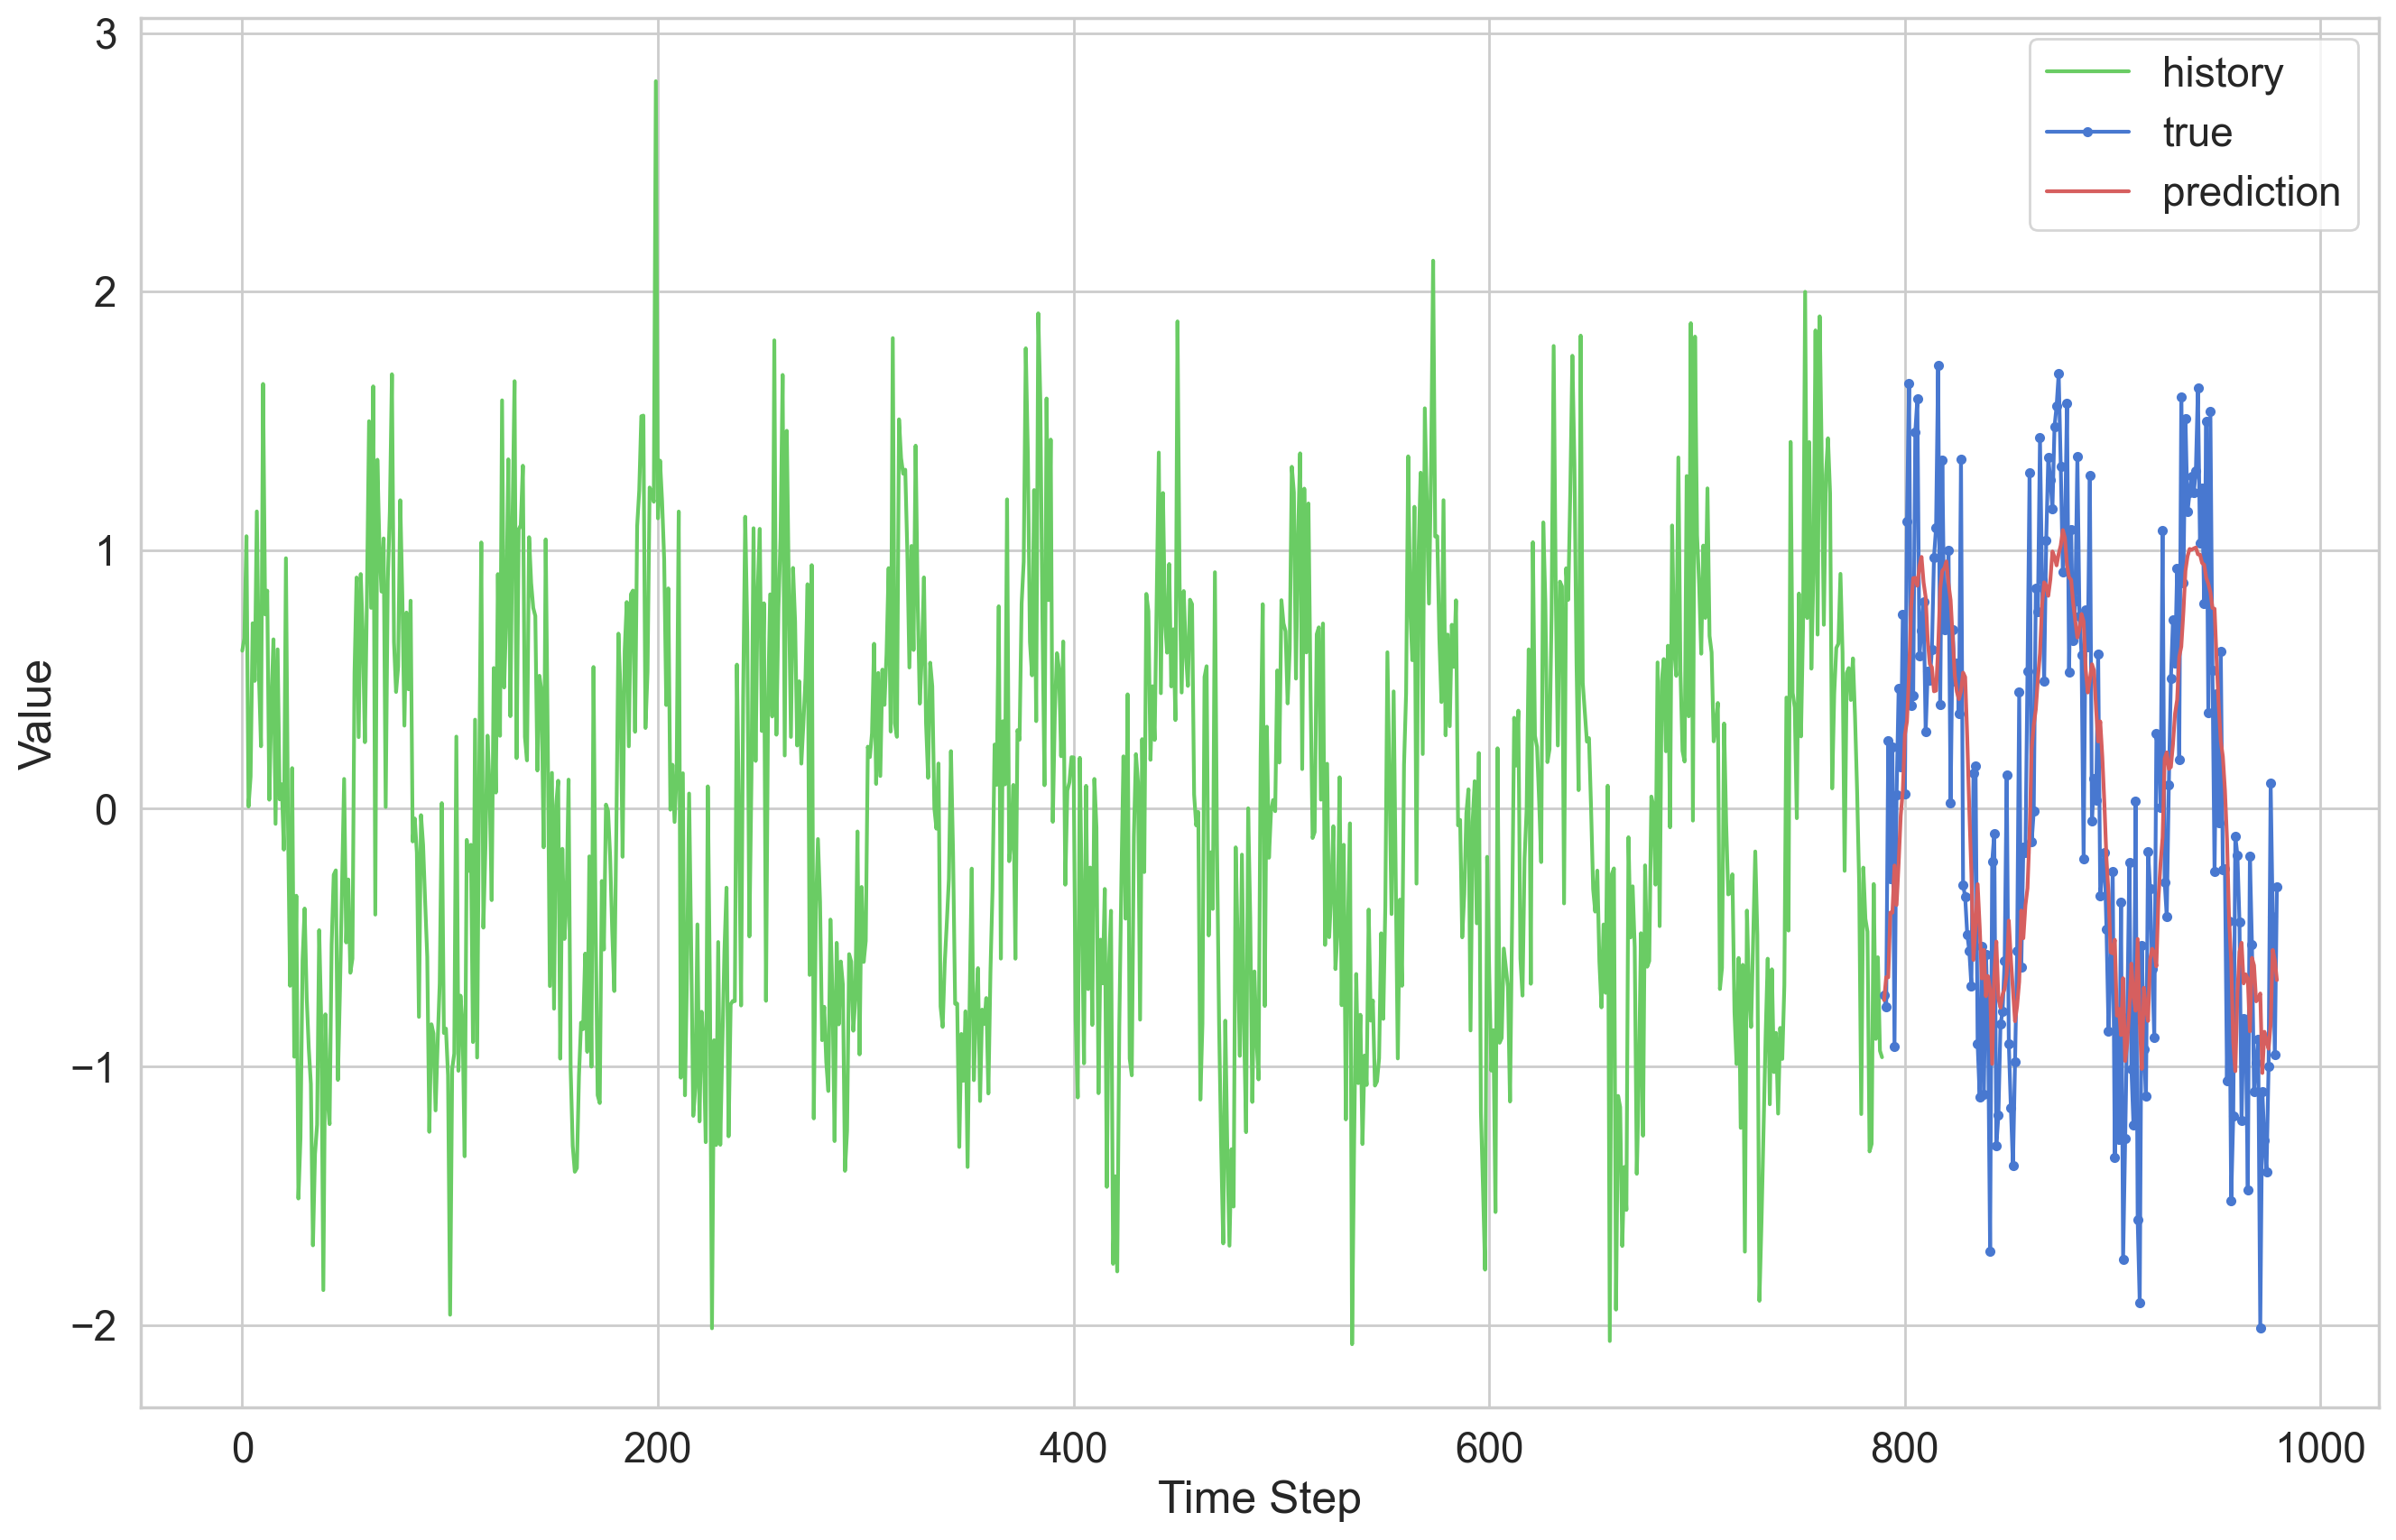

In [17]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

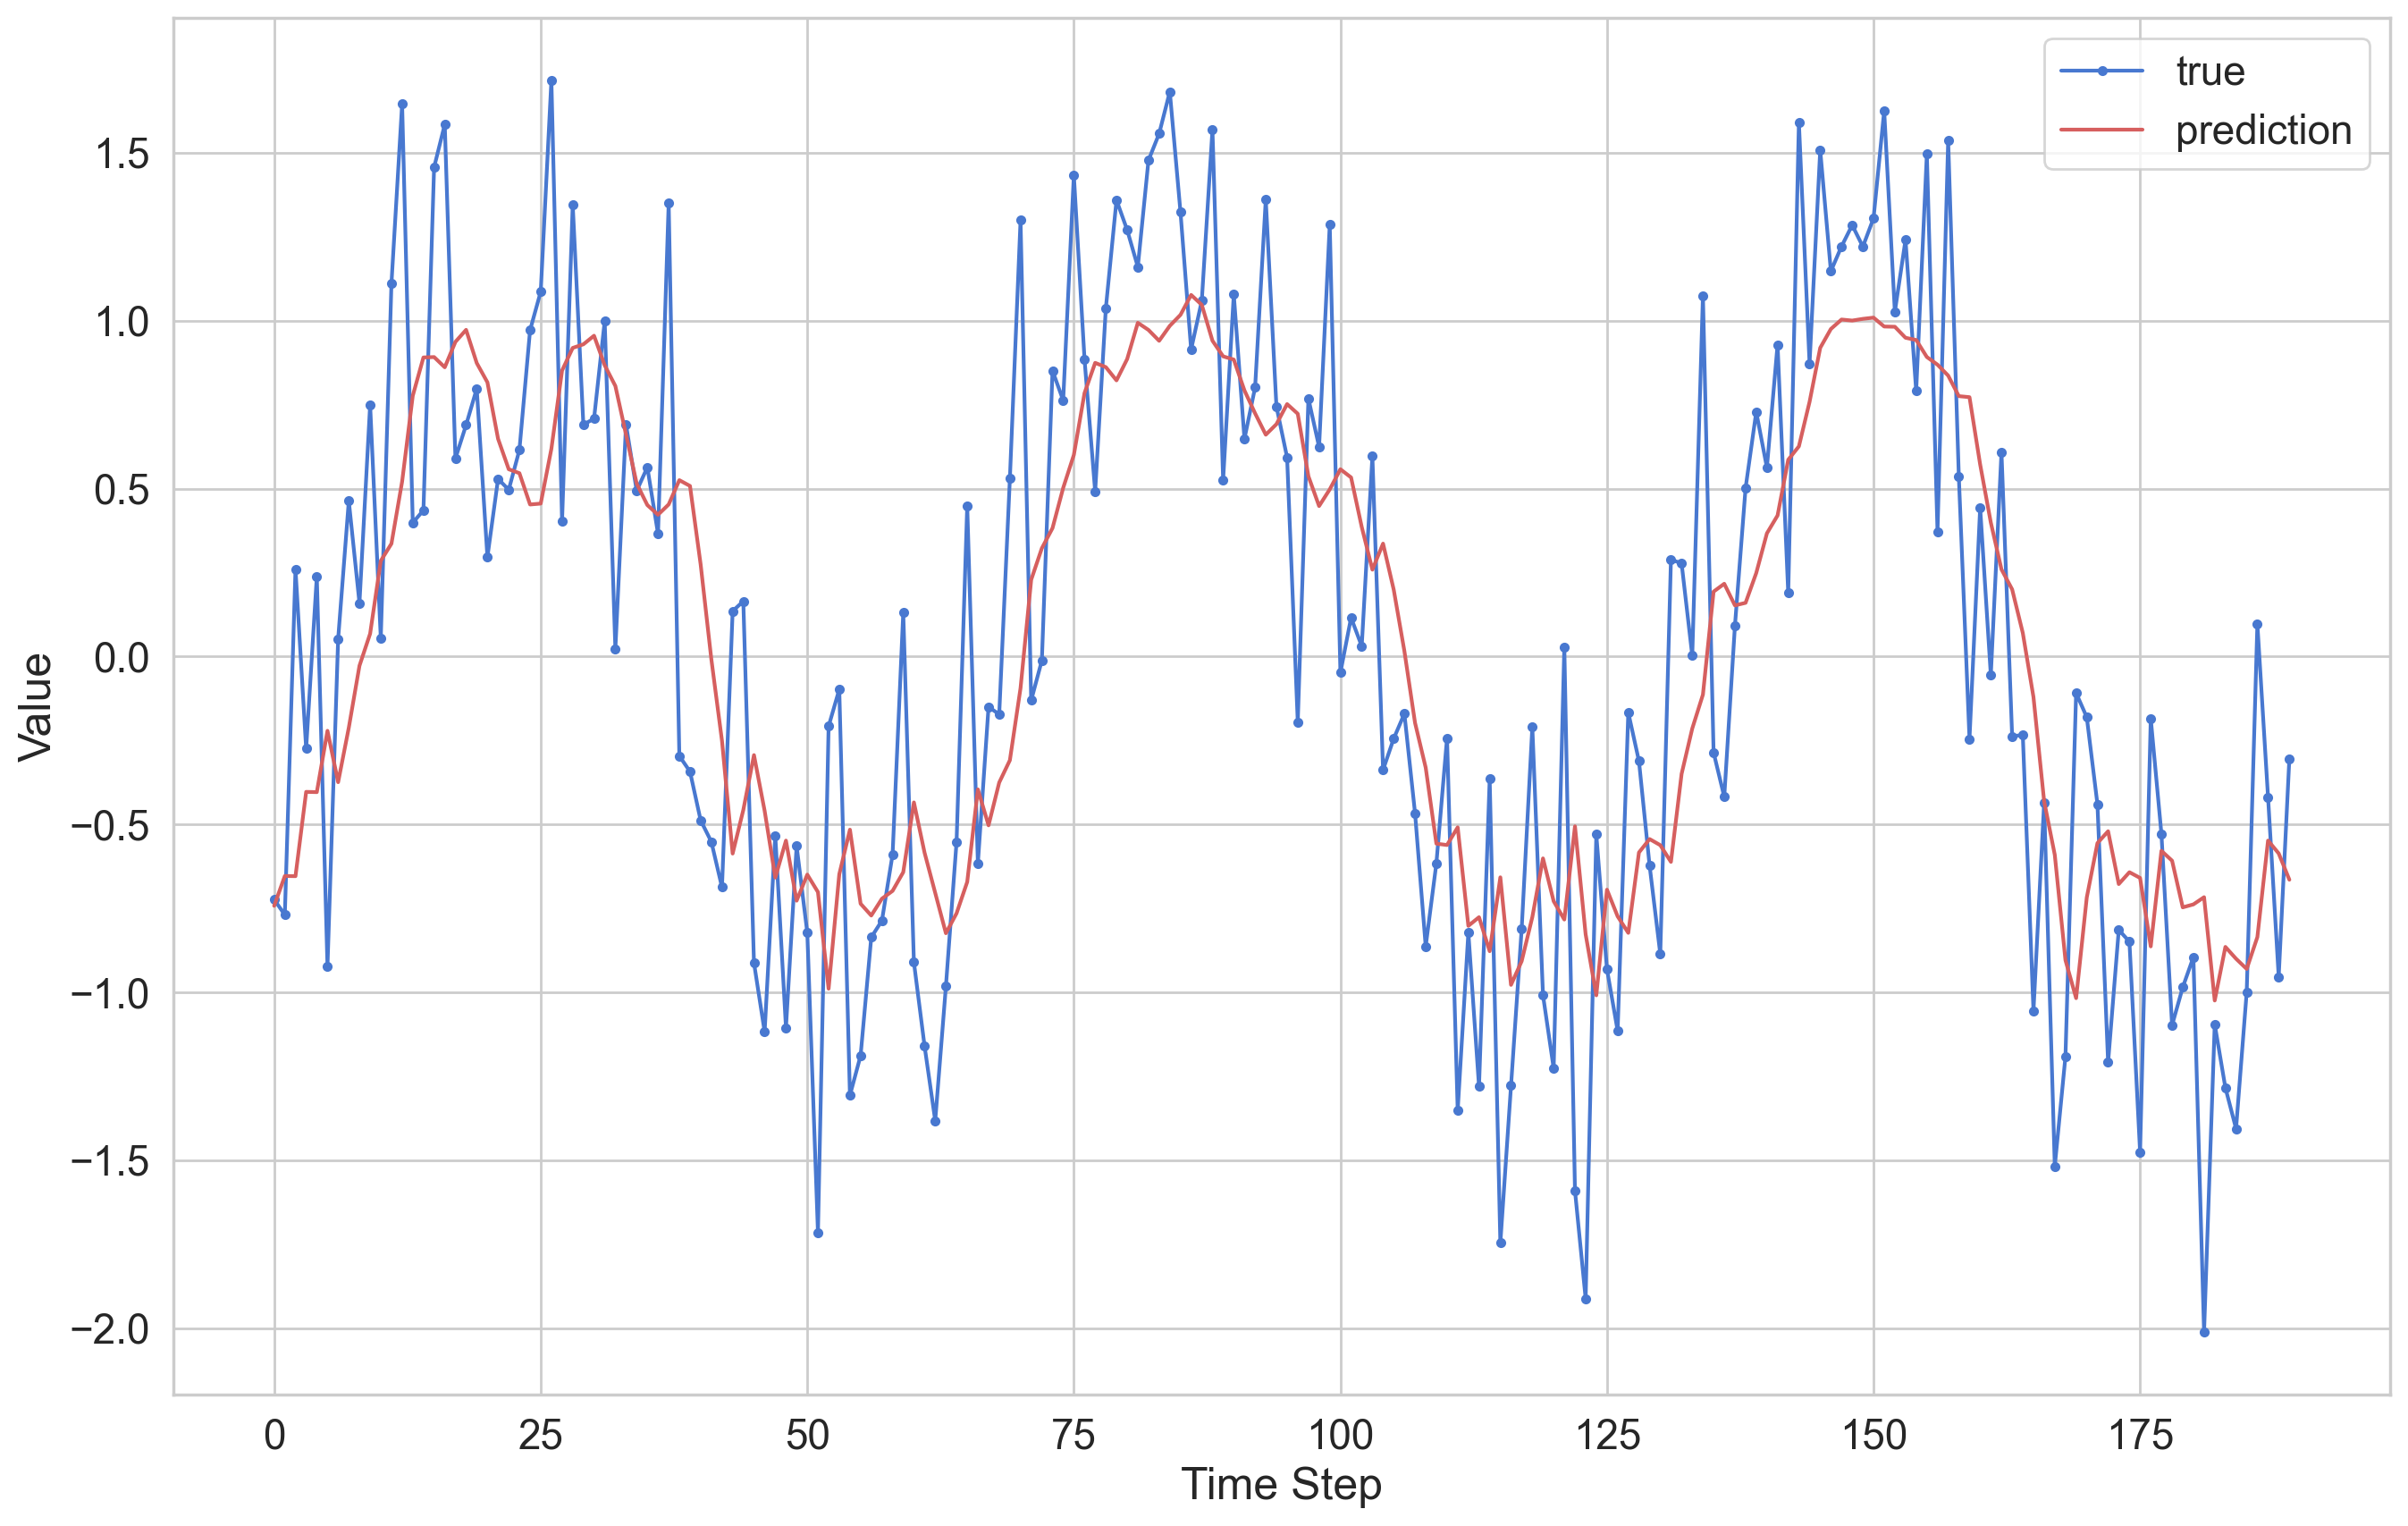

In [18]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();